# II. Sampling and fitting
## 2. -  Fitting telemetry signals with splines

In this notebook we look fit the telemetry signals with splines.  Splines are useful for computing derivatives.  

In [1]:
import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('talk')

In [2]:
import sys, os
sys.path.append(os.path.abspath("../code/"))

Let's read in the temperature data.

In [3]:
from thermals import get_temperature_data_from_suffix, pre_process_temperature_data, get_vector_derivative_spline

In [4]:
import datetime

In [5]:
%%time
file_type = 'TelescopeTemperatureTH_1'
raw_df = get_temperature_data_from_suffix(file_type)
df = pre_process_temperature_data(raw_df, add_jitter=file_type)

CPU times: user 10.5 s, sys: 1.33 s, total: 11.8 s
Wall time: 6.58 s


In [6]:
df.head()

,MJD,LC,SC,TH1SCMNTT,TH2SCMNTT,campaign
2014-03-12 00:19:19.488000,56728.01342,87434,2611480,299.333210,292.978585,0
2014-03-12 00:20:17.376000,56728.01409,87434,2611481,299.517605,292.988700,0
2014-03-12 00:21:15.264000,56728.01476,87434,2611482,299.844323,293.256443,0
2014-03-12 00:22:13.151999,56728.01543,87434,2611483,299.663768,293.055573,0
2014-03-12 00:23:11.904000,56728.01611,87434,2611484,299.670943,292.924491,0


In [7]:
df_c16 = df[df.campaign == 16]

In [8]:
col = 'TH1SCMNTT'

In [9]:
%%time
model, deriv = get_vector_derivative_spline(df_c16.MJD.values, df_c16[col].values, ss=8000)

CPU times: user 520 ms, sys: 7.42 ms, total: 527 ms
Wall time: 168 ms


(736740.0, 736742.0)

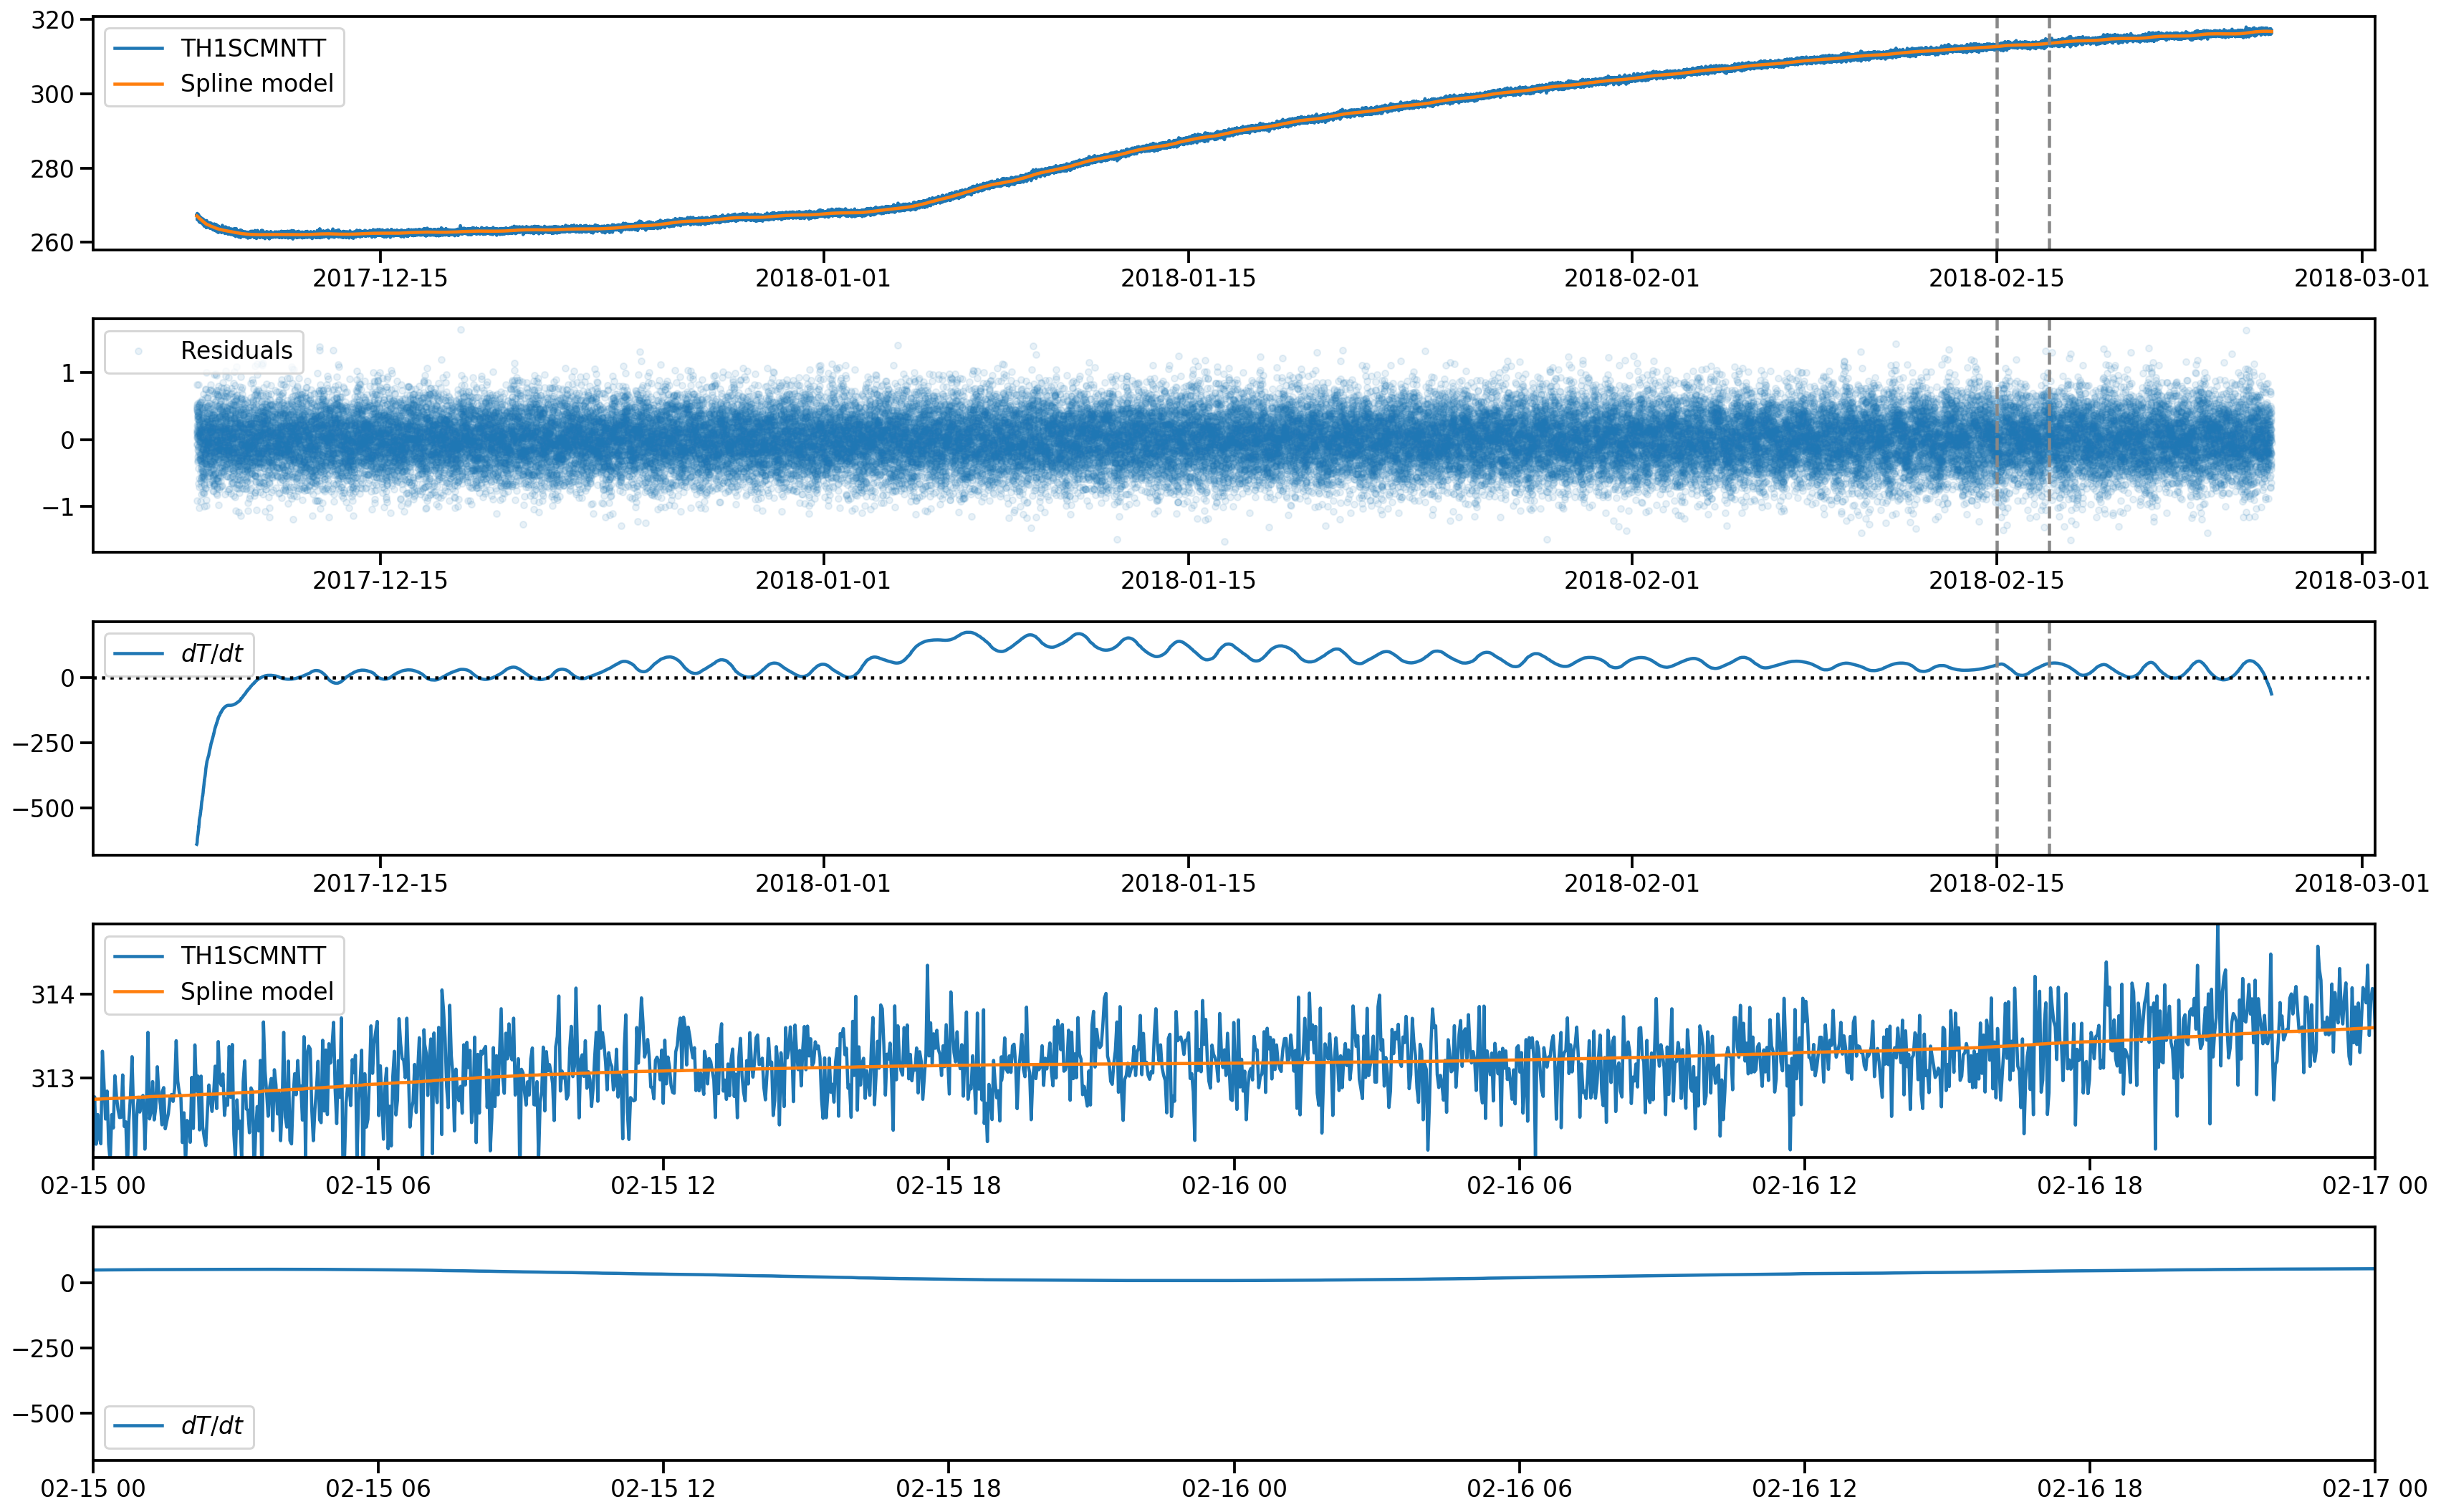

In [10]:
left, right = (datetime.date(2018, 2, 15), datetime.date(2018, 2, 17))

fig, axes = plt.subplots(5, figsize=(24, 15), sharex=False, tight_layout=True)
axes[0].plot(df_c16[col], label=col)
axes[0].plot(df_c16.index, model, label='Spline model')
axes[0].legend()
axes[0].axvline(left, color='#888888', linestyle='dashed')
axes[0].axvline(right, color='#888888', linestyle='dashed')

axes[1].plot(df_c16[col]-model, '.', label='Residuals', alpha=0.1)
axes[1].axvline(left, color='#888888', linestyle='dashed')
axes[1].axvline(right, color='#888888', linestyle='dashed')
axes[1].legend()

axes[2].plot(df_c16.index, deriv, label='$dT/dt$')
axes[2].axhline(0, color='#000000', linestyle='dotted')
axes[2].legend()
axes[2].axvline(left, color='#888888', linestyle='dashed')
axes[2].axvline(right, color='#888888', linestyle='dashed')

axes[3].plot(df_c16[col], label=col)
axes[3].plot(df_c16.index, model, label='Spline model')
axes[3].legend()
axes[3].set_xlim([left, right])
mask = (df_c16.index.date >left) & (df_c16.index.date < right)
axes[3].set_ylim(df_c16[col][mask].min(), df_c16[col][mask].max())

axes[4].plot(df_c16.index, deriv, label='$dT/dt$')
axes[4].legend()
axes[4].set_xlim([left, right])
#axes[4].set_ylim(-3, 3)

Hmm, splines with fixed smoothness-factor are tricky because the signal has regions of large gradients and weak gradients.  The splines with low smoothness factor can overfit noise, making spurious wiggles in the derivative.

**Setting the $S$ parameter is crucial yet tricky**.  We need to do some sort of cross-validation approach, or manually tune each column.